# Plotting a Contour
---
We want to plot a contour of an object based on some selected points.  
Given a list of points $(x_k, y_k),\ k = 0,\ldots,n-1,\ $think of $x$ and $y$ as two functions of an independent variable that goes from $0$ to $n$.  
Now we can use interpolation to approximate the desired $x$ and $y$.

## Piecewise Cubic Hermite Interpolation  
Given $n$ points paired with the function values $(x_k, y_k),\ k = 0,\ldots,n-1,\ $ let $h_k$ denote the length of the $k$th subinterval:  
$$h_k = x_{k+1} - x_k.$$
Then the first divided difference, $\delta_k$, is given by
$$\delta_k = \frac{y_{k+1} - y_k}{h_h}.$$  
Let $d_k$ denote the slope of the interpolant at $x_k$:  
$$d_k = P'(x_k).$$  

In the $k$th subinterval, we require the interpolant $P(x)$ to satisfy four interpolation conditions, two on function values and two on the possibly unknown derivative values:  

$$P(x_k) = y_k,\ P(x_{k+1}) = y_{k+1},$$
$$P'(x_k) = d_k,\ P'(x_{k+1}) = d_{k+1}.$$  

Then in the $k$th subinterval, we can write  
$$P(x) = y_k + sd_k + s^2c_k + s^3b_k,$$  
where $s = x − x_k,\ $and  
$$c_k = \frac{3\delta_k - 2d_k - d_{k+1}}{h_k},$$  
$$b_k = \frac{d_k - 2\delta_k + d_{k+1}}{{h_k}^2}.$$ 

To define the slopes $d_k$, we can apply the following two methods:

### (1) Shape-Preserving Piecewise Cubic 
---
<details><summary>"Visually pleasing " interpolant</summary>
<p> 
The aim is to preserve the shape of the function and have a visually pleasing interpolant.  
We define d_k with following rules:  
    
* For $d_k,\ k = 1,\ldots,n-2$:
    1. If $\delta_k$ and $\delta_{k-1}$ have opposite signs or if either of them is zero, then $x_k$ is a discrete local   minimum or maximum, so we set $d_k = 0$.
    2. If $\delta_k$ and $\delta_{k-1}$ have the same sign, define $dk = w_1\delta_{k-1} + w_2\delta_k,\ $where $w_1 = 2h_k + h_{k−1}, w_2 = h_k + 2h_{k−1}$.  
    
* For $d_0$ at the end of the interval ($d_{n-1}$ can be defined similarly):
    0. First, define $d = \frac{(2h_1 + h_2)\delta_1 - h_1\delta_2}{h_1 + h_2}.$
    1. If $d$ and $\delta_1$ have the same sign, set $d_0 = 0$.  
    2. Otherwise, if $\delta_1$ and $\delta_2$ have the same sign and $|d| > |3\delta_1|,\ $let $d_0 = 3\delta_1.$ 
    3. If neither are the case, set $d_0 = d$.  
</p>
</details>

### (2) Cubic Spline  
---
<details><summary>Interpolant of class $C^2$</summary>
<p> 
Here we have a further requirement that $P(x)$ have a continuous second derivative. In particular, the second derivative is continuous at every knot.  
On the $k$th subinterval,  
$$P''(x) = \frac{(6h - 12s)\delta_k + (6s - 2h)d_{k+1} + (6s - 4h)d_k}{h^2},\quad s = x - x_k.$$
Requiring $P''(x)$ to be continuous at $x = x_k$ means that  
$$P''(x_k^+) = P''(x_k^-),\quad k = 1,\ldots,n-2.$$  
This leads to the condition  
$$\frac{6\delta_k - 2d_{k+1} - 4d_k}{h_k} = \frac{-6\delta_{k-1} + 4d_k + 2d_{k-1}}{h_{k-1}},$$  
$$h_kd_{k−1} + 2(h_{k−1} + h_k)d_k + h_{k−1}d_{k+1} = 3(h_kδ_{k−1} + h_{k−1}δ_k),\quad k = 1,\ldots,n-2.$$  

It gives $n-2$ linear equations of $n$ unknowns $d_k.$  
As for $x_0$ and $x_{n-1}$ at the end of the interval, several approaches can be applied to get two more equations, which we will discuss later.  
So now we have $n$ linear equations in $n$ unknowns: $Ad = r,\ $where  

$$A = \left(\begin{matrix}
            2 &&1 && && && &&\\
            h_1 &&2(h_0+h_1) &&h_0 && && &&\\
             &&h_2 &&2(h_1+h_2) &&h_1 && &&\\
             && &&\ddots &&\ddots &&\ddots &&\\
              && && &&h_{n-2} &&2(h_{n-3}+h_{n-2}) &&h_{n-3}\\
              && && && &&1 &&2
            \end{matrix}\right),$$  
$$d = \left(\begin{matrix}
            d_0\\
            d_1\\
            \vdots\\
            d_{n-1}
            \end{matrix}\right),
\quad
  r = \left(\begin{matrix}
            3\delta_0\\
            3(h_1\delta_0 + h_0\delta_1)\\
            3(h_2\delta_1 + h_1\delta_2)\\
            \vdots\\
            3(h_{n-2}\delta_{n-3} + h_{n-3}\delta_{n-2})\\
            3\delta_{n-2}
            \end{matrix}\right).$$  
</p>
</details>

Import libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded

Define functions to compute slopes for spline and pchip.

In [2]:
def splineslopes(h, delta, n):
    # Getting information of A
    d1 = np.concatenate((h[1:n-1], np.array([1, 0])))
    d2 = np.concatenate((np.array([2]), 2*(h[0:n-2]+h[1:n-1]), np.array([2])))
    d3 = np.concatenate((np.array([0, 1]), h[0:n-2]))
        
    l, u, ab = 1, 1, np.array([d1, d2, d3])
    
    # Forming r
    r = np.concatenate((np.array([3*delta[0]]), 3*(h[1:n-1]*delta[0:n-2] + h[0:n-2]*delta[1:n-1]), np.array([3*delta[n-2]])))
    
    # Solve Ad = r
    return solve_banded((l, u), ab, r)

In [3]:
def pchipend(h1, h2, delta1, delta2):
    d = ((2*h1 + h2)*delta1 - h1*delta2) / (h1 + h2)
    if np.sign(d) == np.sign(delta1):
        d = 0
    elif (np.sign(delta1) == np.sign(delta2)) and (np.abs(d) > np.abs(3*delta1)):
        d = 3*delta1
    return d

def pchipslopes(h, delta, n):
    d = np.zeros(n)
    for k in range(1, n-1):
        if np.sign(delta[k-1]) * np.sign(delta[k]) > 0:
            w1 = 2*h[k] + h[k-1]
            w2 = h[k] + 2*h[k-1]
            d[k] = (w1 + w2) / (w1/delta[k-1] + w2/delta[k])
    d[0] = pchipend(h[0], h[1], delta[0], delta[1])
    d[n-1] = pchipend(h[n-2], h[n-3], delta[n-2], delta[n-3])
    return d

Construct spline interpolation and pchip interpolation.

In [4]:
def geth(x, n):
    return x[1:n] - x[0: n-1] # h_0 to h_n-2. len(h) = n-1

def getdelta(y, h, n):
    return (y[1: n] - y[0:n-1]) / h # delta_0 to delta_n-2. len(delta) = n-1

def getc(delta, d, h, n):
    return (3*delta - 2*d[0:n-1] - d[1:n]) / h #c_0 to c_n-2. len(c) = n-1

def getb(delta, d, h, n):
    return (d[0:n-1] - 2*delta + d[1:n]) / h**2 #b_0 to b_n-2. len(b) = n-1

In [5]:
def myCS(x, y):
    
    # First derivative
    n = len(x)
    h = geth(x, n)
    delta = getdelta(y, h, n)
    d = splineslopes(h, delta, n)
    
    # Piecewise polynomial coefficients
    c = getc(delta, d, h, n)
    b = getb(delta, d, h, n)
    
    def P(U):
        
        notArray = False
        if isinstance(U, (int, float)):
            notArray = True
            U = np.array([U])
        
        value = []
        for u in U:
            # Find subinterval indices k so that x_k <= u < x_k+1
            for k in range(n):
                if np.any(x[k] > u):
                    break
            k -= 1
            
            # Evaluate interpolant
            s = u - x[k]
            value.append(y[k] + d[k]*s + c[k]*s**2 + b[k]*s**3)
        
        if notArray:
            return value[0]
        else:
            return np.array(value)
        
    return P

In [6]:
def myPchip(x, y):
    
    # First derivative
    n = len(x)
    h = geth(x, n)
    delta = getdelta(y, h, n)
    d = pchipslopes(h, delta, n)
    
    # Piecewise polynomial coefficients
    c = getc(delta, d, h, n)
    b = getb(delta, d, h, n)
    
    def P(U):
        
        notArray = False
        if isinstance(U, (int, float)):
            notArray = True
            U = np.array([U])
        
        value = []
        for u in U:
            # Find subinterval indices k so that x_k <= u < x_k+1
            for k in range(n):
                if np.any(x[k] > u):
                    break
            k -= 1
            
            # Evaluate interpolant
            s = u - x[k]
            value.append(y[k] + d[k]*s + c[k]*s**2 + b[k]*s**3)
        
        if notArray:
            return value[0]
        else:
            return np.array(value)
        
    return P

Read a list of points from the file.

In [7]:
pts_x = [] # x coordinate of selected points
pts_y = [] # y coordinate of selected points
with open('..\\points\\star-pts.txt') as f:
    n = int(f.readline()) # number of selected points
    for line in f:
        pt = line.rsplit()
        x, y = float(pt[0]), float(pt[1])
        pts_x.append(x)
        pts_y.append(y)
pts_x = np.asarray(pts_x)
pts_y = np.asarray(pts_y)

Plot the result.

In [8]:
t = np.arange(n)
myp_x = myPchip(t, pts_x)
myp_y = myPchip(t, pts_y)
mycs_x = myCS(t, pts_x)
mycs_y = myCS(t, pts_y)

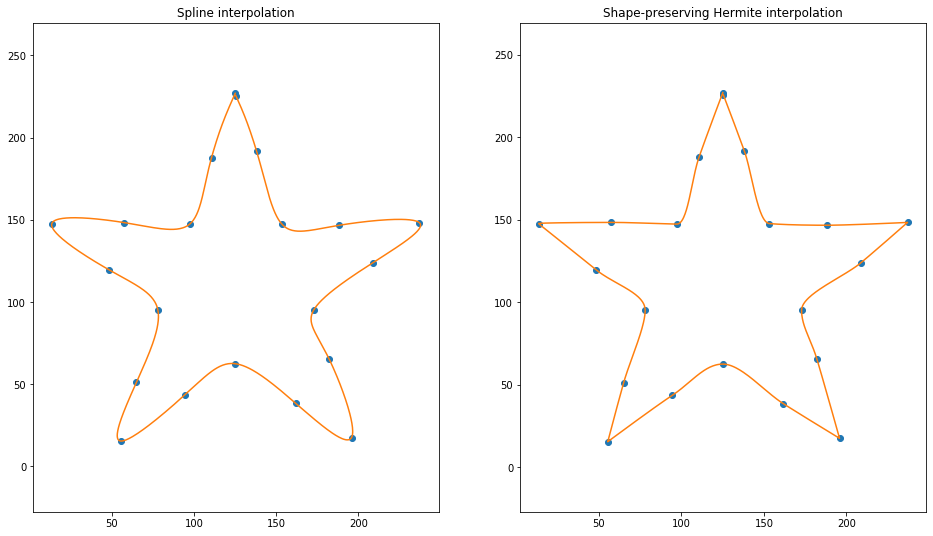

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(16, 9))

t1 = np.linspace(0, n-1, 1000)
ax[0].plot(pts_x, pts_y, 'o')
ax[0].plot(mycs_x(t1), mycs_y(t1))
ax[1].plot(pts_x, pts_y, 'o')
ax[1].plot(myp_x(t1), myp_y(t1))

ax[0].axis('equal')
ax[1].axis('equal')
ax[0].set_title('Spline interpolation')
ax[1].set_title('Shape-preserving Hermite interpolation')
plt.show()

Solve the problem by scipy.interpolate.CubicSpline and scipy.interpolate.PchipInterpolator.

In [10]:
from scipy.interpolate import CubicSpline
from scipy.interpolate import PchipInterpolator
t = np.arange(n)
cs_x = CubicSpline(t, pts_x, bc_type='natural')
cs_y = CubicSpline(t, pts_y, bc_type='natural')
pchip_x = PchipInterpolator(t, pts_x)
pchip_y = PchipInterpolator(t, pts_y)

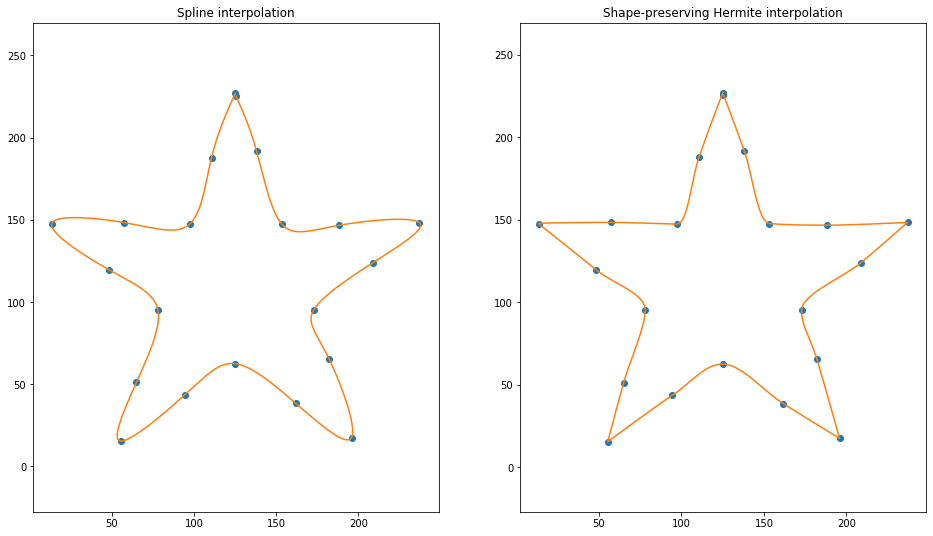

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(16, 9))

t1 = np.linspace(0, n-1, 1000)
ax[0].plot(pts_x, pts_y, 'o')
ax[0].plot(cs_x(t1), cs_y(t1))
ax[1].plot(pts_x, pts_y, 'o')
ax[1].plot(pchip_x(t1), pchip_y(t1))

ax[0].axis('equal')
ax[1].axis('equal')
ax[0].set_title('Spline interpolation')
ax[1].set_title('Shape-preserving Hermite interpolation')
plt.show()